Imports

In [ ]:
import pandas as pd
import numpy as np
import xgboost
from xgboost import XGBClassifier, plot_importance
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn

# import from sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier

# import from xgboost
from xgboost import plot_importance


Load dataset

In [51]:
df = pd.read_csv("synthetic_coffee_health_10000.csv")

Properties of the dataset

In [52]:
print("Shape:", df.shape)    # rows x cols

Shape: (10000, 16)


In [53]:
print("Column types:")
print(df.dtypes)

Column types:
ID                           int64
Age                          int64
Gender                      object
Country                     object
Coffee_Intake              float64
Caffeine_mg                float64
Sleep_Hours                float64
Sleep_Quality               object
BMI                        float64
Heart_Rate                   int64
Stress_Level                object
Physical_Activity_Hours    float64
Health_Issues               object
Occupation                  object
Smoking                      int64
Alcohol_Consumption          int64
dtype: object


In [54]:
print("First 5 rows:")
display(df.head())

First 5 rows:


,ID,Age,Gender,Country,Coffee_Intake,Caffeine_mg,Sleep_Hours,Sleep_Quality,BMI,Heart_Rate,Stress_Level,Physical_Activity_Hours,Health_Issues,Occupation,Smoking,Alcohol_Consumption
0,1,40,Male,Germany,3.5,328.1,7.5,Good,24.9,78,Low,14.5,NaN,Other,0,0
1,2,33,Male,Germany,1.0,94.1,6.2,Good,20.0,67,Low,11.0,NaN,Service,0,0
2,3,42,Male,Brazil,5.3,503.7,5.9,Fair,22.7,59,Medium,11.2,Mild,Office,0,0
3,4,53,Male,Germany,2.6,249.2,7.3,Good,24.7,71,Low,6.6,Mild,Other,0,0
4,5,32,Female,Spain,3.1,298.0,5.3,Fair,24.1,76,Medium,8.5,Mild,Student,0,1


Check for missing values

In [55]:
print("Missing values:")
print(df.isnull().sum())

Missing values:
ID                            0
Age                           0
Gender                        0
Country                       0
Coffee_Intake                 0
Caffeine_mg                   0
Sleep_Hours                   0
Sleep_Quality                 0
BMI                           0
Heart_Rate                    0
Stress_Level                  0
Physical_Activity_Hours       0
Health_Issues              5941
Occupation                    0
Smoking                       0
Alcohol_Consumption           0
dtype: int64


The Health_Issues column has 5941 missing values out of 10000 entries. We will inspect this further.

In [56]:
print(df["Health_Issues"].value_counts())

Health_Issues
Mild        3579
Moderate     463
Severe        17
Name: count, dtype: int64


Looking at the dataset, the 5941 missing values in the Health_Issues column are actually just None - as in no health issues. The system interprets this to be the None keyword = missing value. So we will rename all of these entries so they are no longer considered as missing values.

In [57]:
df["Health_Issues"] = df["Health_Issues"].fillna("No_issues")
print(df["Health_Issues"].value_counts())

Health_Issues
No_issues    5941
Mild         3579
Moderate      463
Severe         17
Name: count, dtype: int64


Now, we check again for missing values.

In [58]:
print("Missing values:")
print(df.isnull().sum())

Missing values:
ID                         0
Age                        0
Gender                     0
Country                    0
Coffee_Intake              0
Caffeine_mg                0
Sleep_Hours                0
Sleep_Quality              0
BMI                        0
Heart_Rate                 0
Stress_Level               0
Physical_Activity_Hours    0
Health_Issues              0
Occupation                 0
Smoking                    0
Alcohol_Consumption        0
dtype: int64


There are no missing values now.

Now we can define the features and target vectors for our classification. We will start with Neural Networks with dropout to decide the best model paramaters out of 16 features.

In [59]:
def get_importance(X, y):
    xgb_model = XGBClassifier(n_estimators=200, # number of boosting rounds = 200 trees
                              max_depth=5, # complexity of each tree
                              learning_rate=0.1, # step size
                              eval_metric='mlogloss',
                              random_state=42)

    xgb_model.fit(X, y)

    # get the important features
    importance = xgb_model.get_booster().get_score(importance_type='gain')

    # get the list of features with their importance
    importance_df = pd.DataFrame({
        'Feature': list(importance.keys()),
        'Importance': list(importance.values())
    })

    # sorting the importance and printing
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    print("")
    return xgb_model, importance_df

def encode_vectors(feature):
    # get the feature and target vectors
    X = df.drop(feature, axis=1)
    y = df[feature].values

    print("Feature vector shape:", X.shape)    # rows x cols
    print("Target vector shape:", y.shape)    # rows x cols

    # Encode all the non-integer or non-float features
    # create and fit encoder to map target values  ['Low','Medium','High'] -> [0,1,2]
    encoder = LabelEncoder()
    y_encoded = encoder.fit_transform(y)

    df_encoded = X.copy()
    # encode feature object values
    for col in df_encoded.select_dtypes(include=['object']).columns:
        df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col])

    #Split into test and validation data sets
    X_train, X_val, y_train, y_val = train_test_split(df_encoded, y_encoded, test_size=0.2, random_state=42)

    return X_train, X_val, y_train, y_val, encoder, df_encoded


In [60]:
# get the feature and target vectors
X_train, X_val, y_train, y_val, encoder, df_encoded = encode_vectors("Stress_Level")

xgb_model, importance_df = get_importance(X_train,y_train)
print(importance_df)

Feature vector shape: (10000, 15)
Target vector shape: (10000,)

         Feature  Importance
2    Sleep_Hours  141.270813
3  Sleep_Quality  106.564705
4  Health_Issues    0.169639
1    Caffeine_mg    0.002241
0            Age    0.001113


As we can recognize from the chart above, features Sleep_Hours and Sleep_Quality contribute the most to stress levels. Since we are trying to find correlation between coffee intake and stress levels, we can look at the cause of sleep quality and health issues.

In [61]:
# get the importance for ["Sleep_Quality"]
print("Displaying the important features for Sleep_Quality:")
X_train_sq, X_val_sq, y_train_sq, y_val_sq, encoder_sq, df_encoded_sq = encode_vectors("Sleep_Quality")

xgb_model_sq, importance_df_sq = get_importance(X_train_sq,y_train_sq)
print(importance_df_sq)

# get the importance for ["Health_Issues"]
print("Displaying the important features for Health_Issues:")
X_train_h, X_val_h, y_train_h, y_val_h, encoder_h, df_encoded_h = encode_vectors("Health_Issues")

xgb_model_h, importance_df_h = get_importance(X_train_h,y_train_h)
print(importance_df_h)

Displaying the important features for Sleep_Quality:
Feature vector shape: (10000, 15)
Target vector shape: (10000,)

                    Feature  Importance
9              Stress_Level  185.210022
6               Sleep_Hours   88.442535
4             Coffee_Intake    0.424574
8                Heart_Rate    0.401869
10  Physical_Activity_Hours    0.384590
2                    Gender    0.350937
1                       Age    0.350908
7                       BMI    0.322662
5               Caffeine_mg    0.293139
12               Occupation    0.290075
0                        ID    0.270564
13                  Smoking    0.239602
14      Alcohol_Consumption    0.188935
3                   Country    0.177488
11            Health_Issues    0.044844
Displaying the important features for Health_Issues:
Feature vector shape: (10000, 15)
Target vector shape: (10000,)

                    Feature  Importance
6               Sleep_Hours   36.463623
1                       Age   22.057611
8   

For visual purposes, we can plot the importance with plot_importance from xgboost.

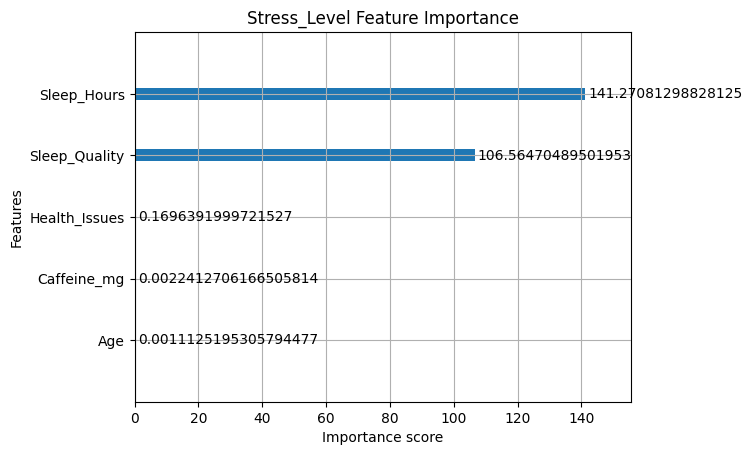

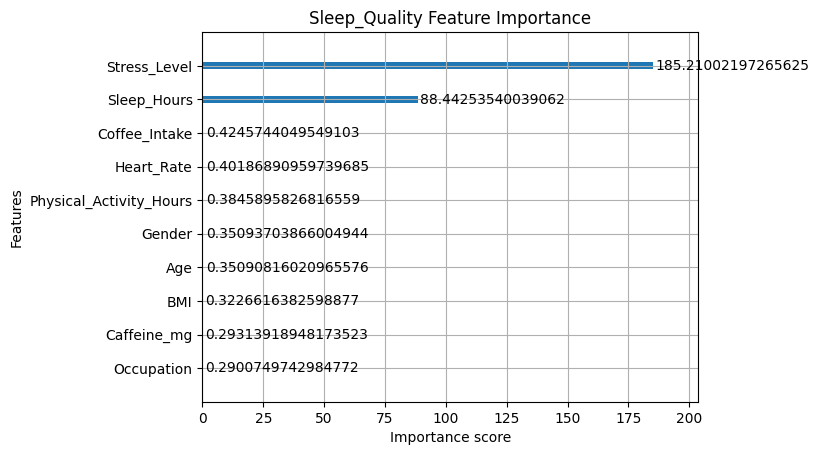

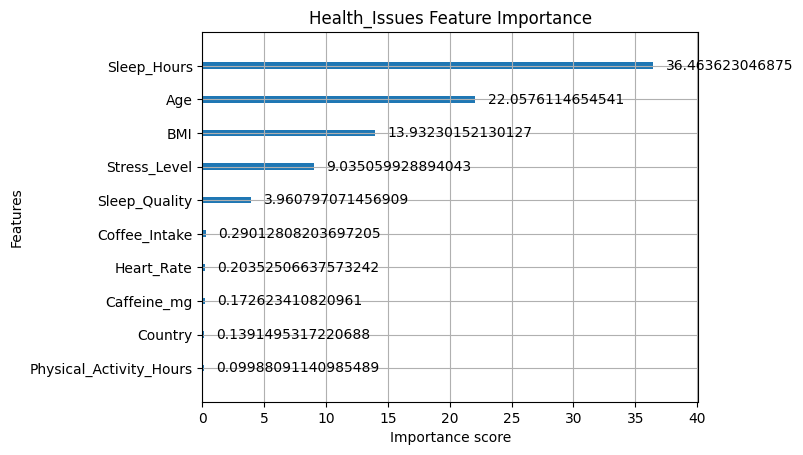

In [62]:
# plotting Stress_Level importance features
plot_importance(xgb_model, max_num_features=10, importance_type='gain', title="Stress_Level Feature Importance")
plt.show()

# plotting Sleep_Quality importance features
plot_importance(xgb_model_sq, max_num_features=10, importance_type='gain', title="Sleep_Quality Feature Importance")
plt.show()

# plotting Health_Issues importance features
plot_importance(xgb_model_h, max_num_features=10, importance_type='gain', title="Health_Issues Feature Importance")
plt.show()

As we can see, Caffeine_mg and Coffee_Intake does play a role in predicting the sleep hours and sleep quality which has an effect on stress levels and health issues.

Now that we have the important features, we can start training and validating models using xgboost with hyperparameter tuning.

In [63]:
def grid_search_func(model, X, y, param_grid):

    # set up grid search
    random_grid_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=20, #20 random combinations
        scoring='accuracy',
        cv=3, # 3-fold cross-validation since one of the classes has only 3 samples for a y-value
        verbose=1, 
        refit=True, # automatically refit the best model on the full dataset
        random_state=42,
        n_jobs=-1
    )

    random_grid_search.fit(X, y)

    # return the best parameters, best score, best fitted model
    return random_grid_search.best_params_, random_grid_search.best_score_, random_grid_search.best_estimator_

def get_accuracy_cm(model, X_train, X_val, y_train, y_val):

    # get the predictions
    y_pred_train = model.predict(X_train) # training predictions
    y_pred_val = model.predict(X_val) # validation predictions

    acc_train = accuracy_score(y_train, y_pred_train)
    acc_val = accuracy_score(y_val, y_pred_val)

    cm_train = confusion_matrix(y_train, y_pred_train) 
    cm_val = confusion_matrix(y_val, y_pred_val) 

    return acc_train, acc_val, cm_train, cm_val

def plotting_cm(model, X_train, y_train, X_val, y_val, param_grid, feature, encoder):
    xgb_bp, xgb_bs, xgb_tuned_model = grid_search_func(model, X_train, y_train, param_grid)
    acc_train, acc_val, cm_train, cm_val = get_accuracy_cm(xgb_tuned_model, X_train, X_val, y_train, y_val)

    print(f"Best parameters: {xgb_bp}, Best score: {xgb_bs}\n")

    disp_cm_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=encoder.classes_)
    disp_cm_val = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=encoder.classes_)

    disp_cm_train.plot(cmap='Greens', values_format='d')  # 'd' for integers
    plt.title(f"[{feature}] Training Confusion Matrix")
    plt.show()

    disp_cm_val.plot(cmap='Greens', values_format='d')  # 'd' for integers
    plt.title(f"[{feature}] Validation Confusion Matrix")
    plt.show()

    return acc_train, acc_val, cm_train, cm_val


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 1.0}, Best score: 1.0



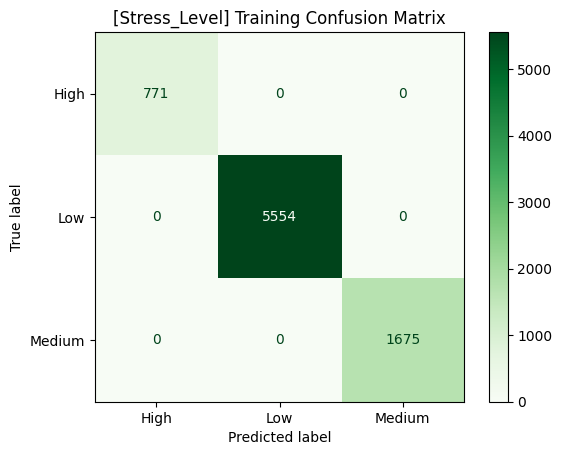

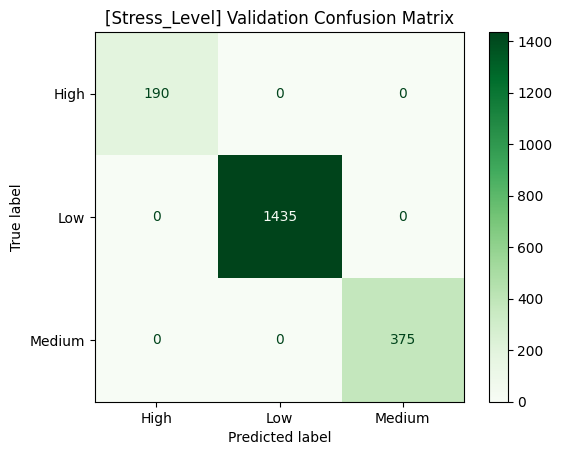

In [ ]:
# define parameters to tune
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.5],
    'subsample': [0.5, 1.0],
    'colsample_bytree': [0.5, 1.0]
}

# select the 5 top features into list
top_5_features = importance_df['Feature'].head(5).tolist()
X_train_top5 = X_train[top_5_features]
X_val_top5 = X_val[top_5_features]


acc_train, acc_val, cm_train, cm_val = plotting_cm(xgb_model, X_train_top5, y_train, X_val_top5, y_val, param_grid, "Stress_Level", encoder)



Due to the large available dataset and high importance pattern for predicting stress levels, our predictions are 100% accurate with this dataset. We can also try predicting the other factors such as Sleep_Quality, and Health_Issues to understand the correlation between coffee intake and health.

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.5, 'colsample_bytree': 1.0}, Best score: 0.9938750154355237



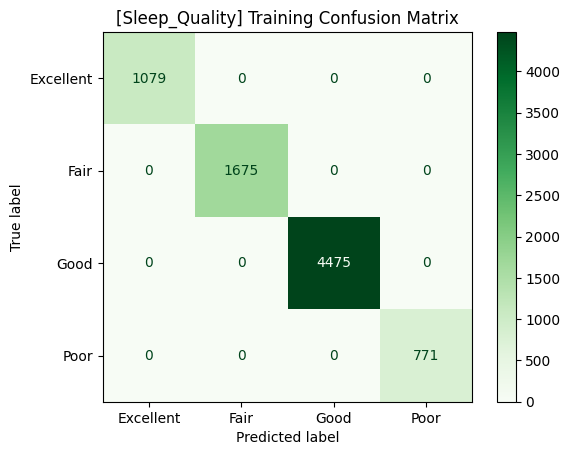

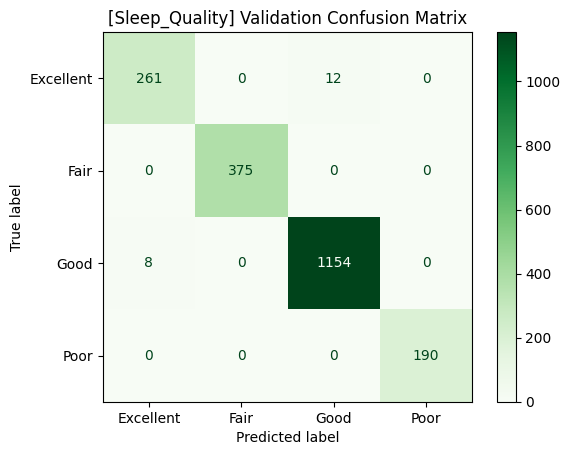

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters: {'subsample': 1.0, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 1.0}, Best score: 0.9982498905566287



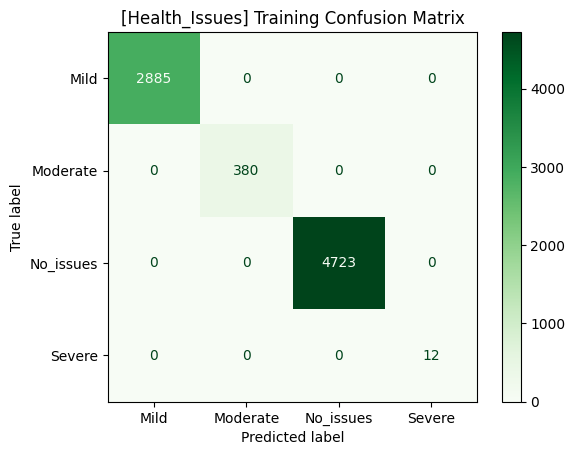

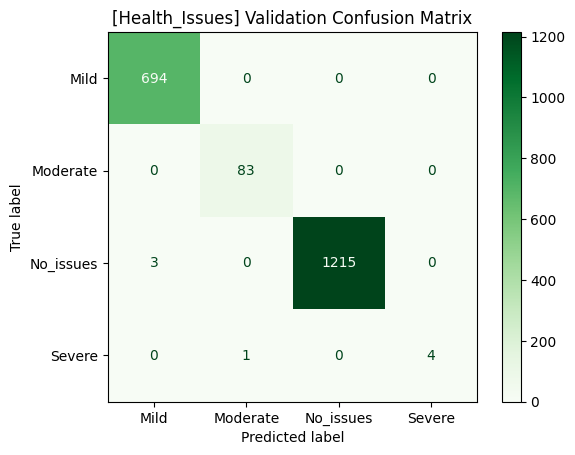

In [65]:
list_features = ["Sleep_Quality", "Health_Issues"]
list_importance_df = [ importance_df_sq, importance_df_h]
list_X_train = [X_train_sq, X_train_h]
list_X_val = [X_val_sq, X_val_h]
list_y_train = [y_train_sq, y_train_h]
list_y_val = [ y_val_sq, y_val_h]
list_encoder = [encoder_sq, encoder_h]
list_model = [xgb_model_sq, xgb_model_h]

acc_dict = {}
for i in range(len(list_features)):

    # select the 5 top features into list
    top_5_features = list_importance_df[i]['Feature'].head(5).tolist()
    X_train_top5 = list_X_train[i][top_5_features]
    X_val_top5 = list_X_val[i][top_5_features]

    # plotting the confustion matrix for the feature
    acc_train, acc_val, cm_train, cm_val = plotting_cm(list_model[i], X_train_top5, list_y_train[i], X_val_top5, list_y_val[i], param_grid, list_features[i], list_encoder[i])

    # add to dictionary to save accuracy and confusion matrix
    acc_dict[list_features[i]] = {
        'acc_train': acc_train,
        'acc_val': acc_val,
        'cm_train': cm_train,
        'cm_val': cm_val
    }
